# Libraries

In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
print(qml.__version__)

0.40.0


# Unitary

In [2]:
single_qubit_two_design = [
    '', 'Y', 'YA', 'YB'
]

def apply_single_two_design(two_design_string, wires):
    for gate in two_design_string:
        if gate == 'Y':
            qml.RY(2*np.arccos(1/np.sqrt(3)), wires=wires)
        elif gate == 'A':
            qml.RZ(2*np.pi/3, wires=wires)
        elif gate == 'B':
            qml.RZ(4*np.pi/3, wires=wires)

def apply_sequence(sequence, wires):
    for two_design in sequence:
        apply_single_two_design(two_design, wires)

def apply_inverse_sequence(sequence, wires):
    for two_design in reversed(sequence):
        apply_single_two_design_adjoint(two_design, wires)

def apply_single_two_design_adjoint(two_design_string, wires):
    for gate in reversed(two_design_string):  # Reverse = important for adjoint
        if gate == 'Y':
            qml.adjoint(qml.RY)(2 * np.arccos(1 / np.sqrt(3)), wires=wires)
        elif gate == 'A':
            qml.adjoint(qml.RZ)(2 * np.pi / 3, wires=wires)
        elif gate == 'B':
            qml.adjoint(qml.RZ)(4 * np.pi / 3, wires=wires)

# Noise

In [3]:
def noise_model(p_ampdamp, wires):
    for wire in wires:
        qml.AmplitudeDamping(p_ampdamp, wires=wire)

# 3-Qubit VGQEC

In [4]:
# code for VGQEC 3 encoding
def VGQEC_3_encoding(wires):
    for wire in wires[1:]:
        qml.CNOT(wires=[0, wire])

# code for variational encoding circuit for 3 qubits
def VGQEC_3_encoding_variational(alpha, L , wires):
    for i in range(L):
        qml.RX(alpha[0], wires=wires[0])     
        qml.RX(alpha[1], wires=wires[1])
        qml.RX(alpha[2], wires=wires[2])

        qml.RY(alpha[3], wires=wires[0])
        qml.RY(alpha[4], wires=wires[1])
        qml.RY(alpha[5], wires=wires[2]) 
    
        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[0, 2])

# code for variational recovery circuit for 3 qubits
def VGQEC_3_recovery_variational(beta, L, wires):

    qml.RZ(beta[0], wires=wires[0])
    qml.RZ(beta[1], wires=wires[1])
    qml.RZ(beta[2], wires=wires[2])
    qml.RZ(beta[3], wires=wires[3])
    qml.RZ(beta[4], wires=wires[4])

    for i in range(L):

        qml.RX(beta[5], wires=wires[0])
        qml.RX(beta[6], wires=wires[1])
        qml.RX(beta[7], wires=wires[2])
        qml.RX(beta[8], wires=wires[3])
        qml.RX(beta[9], wires=wires[4])

        qml.RZ(beta[0], wires=wires[0])
        qml.RZ(beta[1], wires=wires[1])
        qml.RZ(beta[2], wires=wires[2])
        qml.RZ(beta[3], wires=wires[3])
        qml.RZ(beta[4], wires=wires[4])

        qml.IsingZZ(beta[10], wires=[0, 1])
        qml.IsingZZ(beta[11], wires=[1, 2])
        qml.IsingZZ(beta[12], wires=[2, 3])
        qml.IsingZZ(beta[13], wires=[3, 4])
        qml.IsingZZ(beta[14], wires=[0, 2])
        qml.IsingZZ(beta[15], wires=[2, 4])
        qml.IsingZZ(beta[16], wires=[1, 3])
        qml.IsingZZ(beta[17], wires=[0, 3])
        qml.IsingZZ(beta[18], wires=[1, 4])
        qml.IsingZZ(beta[19], wires=[0, 4])

    qml.RX(beta[5], wires=wires[0])
    qml.RX(beta[6], wires=wires[1])
    qml.RX(beta[7], wires=wires[2])
    qml.RX(beta[8], wires=wires[3])
    qml.RX(beta[9], wires=wires[4])

    qml.RZ(beta[0], wires=wires[0])
    qml.RZ(beta[1], wires=wires[1])
    qml.RZ(beta[2], wires=wires[2])
    qml.RZ(beta[3], wires=wires[3])
    qml.RZ(beta[4], wires=wires[4])

# code for recovery map circuit for 3 qubits 
def VGQEC_3_recovery(wires):
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 1])
    qml.Toffoli(wires=[2, 1, 0])
    
    


# 3-Qubit VGQEC

# Optimization for multiple noise parameters for pytorch

In [ ]:
import pennylane as qml
import numpy as np
import torch
import time

lengths = list(range(0, 10, 3))
N_k = 10

# Use a backprop-compatible device
dev_opt = qml.device("default.mixed", wires=5, shots=None)  # Analytic mode for backprop

# Define the circuit with torch interface
def circuit_opt_torch(params, noise):
    wrapped_params = params % (2 * np.pi)
    alpha = wrapped_params[:6]
    beta = wrapped_params[6:]

    fidelities = []

    for k in lengths:
        fidelities_k = []

        for _ in range(N_k):
            sequence = np.random.choice(single_qubit_two_design, size=k)

            @qml.qnode(dev_opt, interface='torch', diff_method='backprop')
            def qnode(p):
                a = (p[:6]) % (2 * np.pi)
                b = (p[6:]) % (2 * np.pi)
                apply_sequence(sequence, wires=0)
                VGQEC_3_encoding(wires=[0, 1, 2])
                VGQEC_3_encoding_variational(a, 2, wires=[0, 1, 2])
                noise_model(noise, wires=[0, 1, 2])
                VGQEC_3_recovery_variational(b, 3, wires=[0, 1, 2, 3, 4])
#                 VGQEC_3_recovery(wires=[0, 1, 2])
                apply_inverse_sequence(sequence, wires=0)
                return qml.expval(qml.Projector([0], wires=0))

            fidelity = qnode(wrapped_params)
            fidelities_k.append(fidelity)

        fidelities.append(torch.mean(torch.stack(fidelities_k)))
        
#         print("fid: ", -torch.mean(torch.stack(fidelities)))

    return -torch.mean(torch.stack(fidelities))

/Applications/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from scipy.interpolate import make_interp_spline

# PyTorch optimization loop using L-BFGS
def torch_optimize(init_params, step_num, noise, verbose=False):
    params = torch.tensor(init_params, dtype=torch.float64, requires_grad=True)
    optimizer = torch.optim.LBFGS([params], max_iter=20, history_size=10, line_search_fn="strong_wolfe")
    costs = []
    times = []

    for i in range(step_num):
        start_time = time.time()

        def closure():
            optimizer.zero_grad()
            cost = circuit_opt_torch(params, noise)

            # Ensure the cost is differentiable
            if not cost.requires_grad:
                raise RuntimeError("Cost does not require grad! Check QNode diff_method and device shots.")

            cost.backward()
            return cost

        cost = closure()
        optimizer.step(closure)
        costs.append(cost.item())
        times.append(time.time() - start_time)

        if verbose and (i + 1) % 10 == 0:
            print(f"Step {i + 1} Cost: {cost.item():.6f}")

    return params.detach().numpy(), costs, times


def call_plot(all_cost, all_noise):
    x = np.array(all_noise)
    y = np.array(all_cost)

    plt.figure(figsize=(7, 5))

    plt.plot(x, y, color='green', linestyle='-', label='Three-qubit VGQEC code')

    plt.xlabel(r'$\lambda$', fontsize=14)
    plt.ylabel('Channel Fidelity', fontsize=14)
    plt.title('Amplitude Damping Noise', fontsize=16)
    plt.xlim(0.0, 0.5)
    plt.ylim(0.75, 1.01)

    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12, frameon=True, loc='lower left')

    plt.tight_layout()
    plt.show()


Step 10, Cost: -0.999363
Step 20, Cost: -0.999391
Step 30, Cost: -0.999427
Step 40, Cost: -0.999593
Step 50, Cost: -0.999641
Step 60, Cost: -0.999655
Step 70, Cost: -0.999683
Step 80, Cost: -0.999873
Step 90, Cost: -0.999909
Step 100, Cost: -0.999898
noise =  0 ; avg cost =  0.9998981481384679 

Step 10, Cost: -0.947898
Step 20, Cost: -0.945919
Step 30, Cost: -0.952965
Step 40, Cost: -0.964400
Step 50, Cost: -0.968641
Step 60, Cost: -0.973646
Step 70, Cost: -0.970619
Step 80, Cost: -0.969503
Step 90, Cost: -0.965175
Step 100, Cost: -0.967761
noise =  0.05 ; avg cost =  0.9677605852294453 

Step 10, Cost: -0.898763
Step 20, Cost: -0.911736
Step 30, Cost: -0.938432
Step 40, Cost: -0.946840
Step 50, Cost: -0.946860
Step 60, Cost: -0.955743
Step 70, Cost: -0.948123
Step 80, Cost: -0.951211
Step 90, Cost: -0.944671
Step 100, Cost: -0.952306
noise =  0.1 ; avg cost =  0.9523061739420778 

Step 10, Cost: -0.921718
Step 20, Cost: -0.920755
Step 30, Cost: -0.913969
Step 40, Cost: -0.934080
Step

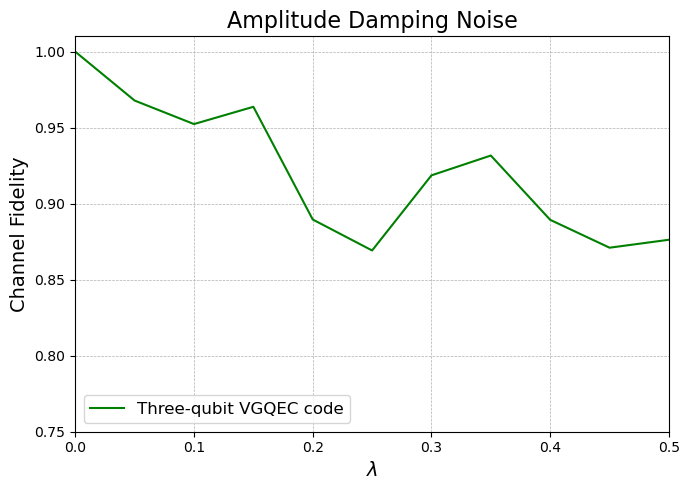

In [ ]:
# # Initialize parameters
# np.random.seed(42)
# initial_params = np.random.normal(0, np.pi, 26)  # Sampling from normal distribution

# # Run PyTorch L-BFGS optimizer
# step_num = 10  # Number of external steps (each may have multiple internal updates)
# opt_params, costs, times = torch_optimize(initial_params, step_num, noise, verbose=True)

# # Extract final alpha and beta
# alpha_opt = opt_params[:6]
# beta_opt = opt_params[6:]

# print("Optimized alpha:", alpha_opt)
# print("Optimized beta:", beta_opt)
# print("Final cost:", -costs[-1])


noise = 0
all_cost = []
all_noise = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for noise in all_noise:
        
    # Initialize parameters
    np.random.seed(42)
    initial_params = np.random.normal(0, np.pi, 26)  # Sampling from normal distribution

    # Run PyTorch L-BFGS optimizer
    step_num = 100  # Number of external steps (each may have multiple internal updates)
    opt_params, costs, times = torch_optimize(initial_params, step_num, noise, verbose=True)

    all_cost.append(-costs[-1])      

    print("noise = ", noise, "; avg cost = ", (-costs[-1]), "\n")
    

call_plot(all_cost, all_noise)

In [ ]:
print("cost: ", all_cost, "\n")
print("noise: ", all_noise)

# call_plot(all_cost, all_noise)

cost:  [0.9998981481384679, 0.9677605852294453, 0.9523061739420778, 0.9636664990446263, 0.8895484577610976, 0.8691863463517492, 0.9185875060358675, 0.9316162495231525, 0.8893291503747769, 0.8710069259502881, 0.8762332203779781] 

noise:  [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
